In [2]:
library(readr)
library(plyr)
library(dplyr)
library(ggplot2)
library(data.table)
library(bit64)
library(sqldf)
library(arulesViz)
library(entropy)
library(arules)
library(xlsx)
library(tibble)
library(BBmisc)
library(tibble)
library(cluster)
library(NbClust)

### Load POS data

In [3]:
d_local = read_csv("C:\\Users\\I347687\\Desktop\\Salling Group\\VT\\Final\\Online Retail\\OnlineRetail.csv")
d_local = d_local[c('InvoiceNo', 'Description', 'Quantity', 'CustomerID')]
colnames(d_local) = c('basket_id', 'article_description', 'quantity', 'shopper_id')
d_local = d_local %>% 
  mutate(article = group_indices_(d_local, .dots=c("article_description")))
head(d_local)

Parsed with column specification:
cols(
  InvoiceNo = col_character(),
  StockCode = col_character(),
  Description = col_character(),
  Quantity = col_double(),
  InvoiceDate = col_character(),
  UnitPrice = col_double(),
  CustomerID = col_double(),
  Country = col_character()
)

Warning message:
"`group_indices_()` is deprecated as of dplyr 0.7.0.
Please use `group_indices()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."
Warning message:
"The `...` argument of `group_keys()` is deprecated as of dplyr 1.0.0.
Please `group_by()` first
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


basket_id,article_description,quantity,shopper_id,article
<chr>,<chr>,<dbl>,<dbl>,<int>
536365,WHITE HANGING HEART T-LIGHT HOLDER,6,17850,4014
536365,WHITE METAL LANTERN,6,17850,4022
536365,CREAM CUPID HEARTS COAT HANGER,8,17850,919
536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,17850,1947
536365,RED WOOLLY HOTTIE WHITE HEART.,6,17850,2967
536365,SET 7 BABUSHKA NESTING BOXES,2,17850,3221


### Select relevant data

In [4]:
# Find out the most frequent categories
frequency = as.data.frame(sort(table(d_local$article_description), decreasing = TRUE))
colnames(frequency) = c ("article_description", "frequency")
fast_movers = frequency %>% top_n(n() * 0.15)
#Select fast movers from POS data
d_local_fast_movers = d_local[d_local$article_description %in% fast_movers$article_description,]
d_local_fast_movers = na.omit(d_local_fast_movers)

Selecting by frequency



# Step nº1 - Apriori

### Prepare the data for Apriori

In [5]:
associate_data_set_shopper = d_local_fast_movers[,c("article_description","shopper_id")]
write.csv(associate_data_set_shopper, file = "C:\\Users\\I347687\\Desktop\\Salling Group\\VT\\Final\\Online Retail\\script output\\associate_data_set_shopper.csv", row.names = F)
transactions_fast_movers_shopper <- read.transactions(file = "C:\\Users\\I347687\\Desktop\\Salling Group\\VT\\Final\\Online Retail\\script output\\associate_data_set_shopper.csv", 
                                                      header = T, format = "single", sep = ",", cols = c(2,1), rm.duplicates = TRUE)

### Apply apriori

In [6]:
transaction_rules_shopper_id_fast_movers <- apriori(transactions_fast_movers_shopper, parameter = list(
  support = 0.00001,
  confidence = 0.00001,
  minlen = 2,
  maxlen = 2))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
      1e-05    0.1    1 none FALSE            TRUE       5   1e-05      2
 maxlen target  ext
      2  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 0 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[635 item(s), 4295 transaction(s)] done [0.03s].
sorting and recoding items ... [635 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2

Warning message in apriori(transactions_fast_movers_shopper, parameter = list(support = 1e-05, :
"Mining stopped (maxlen reached). Only patterns up to a length of 2 returned!"


 done [0.01s].
writing ... [402236 rule(s)] done [0.67s].
creating S4 object  ... done [0.07s].


### Save apriori results into data frame

In [7]:
rule_data = DATAFRAME(transaction_rules_shopper_id_fast_movers,
                      separate = TRUE, 
                      setStart = '', 
                      itemSep = ',', 
                      setEnd = '')

rule_data$LHS = as.character(rule_data$LHS)
rule_data$RHS = as.character(rule_data$RHS)
head(rule_data)

,LHS,RHS,support,confidence,coverage,lift,count
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,DOTCOM POSTAGE,OWL DOORSTOP,0.0002328289,1.00000000,0.0002328289,53.02469,1
2,OWL DOORSTOP,DOTCOM POSTAGE,0.0002328289,0.01234568,0.0188591385,53.02469,1
3,DOTCOM POSTAGE,"RECORD FRAME 7"" SINGLE SIZE",0.0002328289,1.00000000,0.0002328289,58.83562,1
4,"RECORD FRAME 7"" SINGLE SIZE",DOTCOM POSTAGE,0.0002328289,0.01369863,0.0169965076,58.83562,1
5,DOTCOM POSTAGE,ROTATING LEAVES T-LIGHT HOLDER,0.0002328289,1.00000000,0.0002328289,54.36709,1
6,ROTATING LEAVES T-LIGHT HOLDER,DOTCOM POSTAGE,0.0002328289,0.01265823,0.0183934808,54.36709,1


### Create cannibalization table
#### Cannialization table was created via SQL commands to make it replicable in HANA

In [8]:
#### Aggregate the data
d_local_fast_movers_agg = sqldf("select basket_id, article, article_description, shopper_id
      from d_local_fast_movers
      group by basket_id, article, article_description, shopper_id")

In [9]:
#### Count when product 1 and product 2 was in the same basket for each shopper id
same_basket_d_local_bread_cookies_fast_movers_agg_shopper_id = 
  sqldf(
    "select PRODUCT1, PRODUCT2, count(*) as count, shopper_id
    from (
    select 
    T1.article_description AS PRODUCT1,
    T1.shopper_id,
    T2.article_description AS PRODUCT2
    from d_local_fast_movers_agg as T1 INNER JOIN d_local_fast_movers_agg as T2 
    ON T1.basket_id = T2.basket_id and T1.article > T2.article
    )
    group by PRODUCT1, PRODUCT2, shopper_id
    ORDER BY count(*) desc", method="raw")

In [10]:
#### Count when product 1 and product 2 was in the same basket for different shopper id
same_basket_d_local_bread_cookies_fast_movers_agg_dif_shopper = sqldf('select PRODUCT1, PRODUCT2, count(*) as count_same_basket
                                                                      from same_basket_d_local_bread_cookies_fast_movers_agg_shopper_id
                                                                      group by PRODUCT1, PRODUCT2', method = "raw")


In [11]:
#Canibilizers that were in the same basket at least once
identify_cannibilizers = 
  sqldf('select T1.LHS,  T1.RHS, T1.support, T1.confidence, T1.lift, T1.count as count_apriori,
        T2.count_same_basket, round((1 - (cast(T2.count_same_basket as real)/cast(T1.count as real)))*100, 2) as cannibalization_ratio
        FROM rule_data as T1
        INNER JOIN same_basket_d_local_bread_cookies_fast_movers_agg_dif_shopper T2 on T1.LHS = T2.PRODUCT2 AND T1.RHS = T2.PRODUCT1
        
        
        union
        
        select T1.LHS,  T1.RHS, T1.support, T1.confidence, T1.lift, T1.count as count_apriori,
        T2.count_same_basket, round((1 - (cast(T2.count_same_basket as real)/cast(T1.count as real)))*100, 2) as cannibalization_ratio
        FROM rule_data as T1
        INNER JOIN same_basket_d_local_bread_cookies_fast_movers_agg_dif_shopper T2 on T1.LHS = T2.PRODUCT1 AND T1.RHS = T2.PRODUCT2
        ORDER BY T1.count desc', method = "raw")

In [12]:
#Canibilizers that never were in the same basket
identify_cannibilizers_never_in_same_basket = 
  
  sqldf(' select q1.LHS, q1.RHS, q1.support, q1.confidence, q1.lift, q1.count_apriori, q1.count_same_basket, q1.cannibalization_ratio 

        from (

        select T1.LHS, T1.RHS, T1.support, T1.confidence, T1.lift, T1.count as count_apriori, 0 as count_same_basket, 100 as cannibalization_ratio
        FROM rule_data as T1
        left join same_basket_d_local_bread_cookies_fast_movers_agg_dif_shopper t2 on t1.LHS=t2.PRODUCT1 AND t1.RHS = t2.PRODUCT2
        WHERE t2.PRODUCT1 IS NULL AND t2.PRODUCT2 IS NULL) q1
        
        inner join 
        
        (select T1.LHS, T1.RHS, T1.support, T1.confidence, T1.lift, T1.count as count_apriori, 0 as count_same_basket, 100 as cannibalization_ratio
        FROM rule_data as T1
        left join same_basket_d_local_bread_cookies_fast_movers_agg_dif_shopper t2 on t1.LHS=t2.PRODUCT2 AND t1.RHS = t2.PRODUCT1
        WHERE t2.PRODUCT1 IS NULL AND t2.PRODUCT2 IS NULL) q2
        
        on q1.LHS = q2.LHS and q1.RHS = q2.RHS
        
      ',method="raw")

In [13]:
identify_cannibilizers_final  = 
  sqldf('select * from identify_cannibilizers
        union
        select * from identify_cannibilizers_never_in_same_basket', method = "raw")
head(identify_cannibilizers_final[identify_cannibilizers_final$cannibalization_ratio>75 & identify_cannibilizers_final$count_apriori>100,])

,LHS,RHS,support,confidence,lift,count_apriori,count_same_basket,cannibalization_ratio
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
66070,CHRISTMAS CRAFT LITTLE FRIENDS,FELTCRAFT 6 FLOWER FRIENDS,0.02444703,0.3291536,4.194999,105,25,76.19
101962,FELTCRAFT 6 FLOWER FRIENDS,CHRISTMAS CRAFT LITTLE FRIENDS,0.02444703,0.3115727,4.194999,105,25,76.19
154067,JUMBO BAG 50'S CHRISTMAS,JUMBO BAG DOILEY PATTERNS,0.03143190,0.3452685,4.959627,135,16,88.15
156598,JUMBO BAG DOILEY PATTERNS,JUMBO BAG 50'S CHRISTMAS,0.03143190,0.4515050,4.959627,135,16,88.15
156604,JUMBO BAG DOILEY PATTERNS,JUMBO BAG PAISLEY PARK,0.02374854,0.3411371,6.370365,102,0,100.00
156613,JUMBO BAG DOILEY PATTERNS,JUMBO BAG VINTAGE CHRISTMAS,0.02374854,0.3411371,5.123021,102,12,88.24


# Step nº2 - Hierarchical clustering

### Prepare data for HC - create KPI_1 (Substitution score)

In [14]:
range01 <- function(x){(x-min(x))/(max(x)-min(x))}
identify_cannibilizers_final$KPI_1 = identify_cannibilizers_final$lift * identify_cannibilizers_final$cannibalization_ratio
identify_cannibilizers_final$KPI_1_std = range01(identify_cannibilizers_final$KPI_1)
identify_cannibilizers_final$KPI_1_std_inverse = 1 - identify_cannibilizers_final$KPI_1_std
head(identify_cannibilizers_final)

,LHS,RHS,support,confidence,lift,count_apriori,count_same_basket,cannibalization_ratio,KPI_1,KPI_1_std,KPI_1_std_inverse
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,10 COLOUR SPACEBOY PEN,12 MESSAGE CARDS WITH ENVELOPES,0.002328289,0.05586592,1.599628,10,4,60.00,95.97765,0.06167598,0.9383240
2,10 COLOUR SPACEBOY PEN,12 PENCIL SMALL TUBE WOODLAND,0.007683353,0.18435754,4.124040,33,19,42.42,174.94177,0.11241892,0.8875811
3,10 COLOUR SPACEBOY PEN,12 PENCILS SMALL TUBE RED RETROSPOT,0.007217695,0.17318436,3.220030,31,21,32.26,103.87815,0.06675290,0.9332471
4,10 COLOUR SPACEBOY PEN,12 PENCILS SMALL TUBE SKULL,0.006286380,0.15083799,3.322303,27,20,25.93,86.14733,0.05535893,0.9446411
5,10 COLOUR SPACEBOY PEN,12 PENCILS TALL TUBE RED RETROSPOT,0.004889406,0.11731844,2.723690,21,9,57.14,155.63166,0.10001010,0.8999899
6,10 COLOUR SPACEBOY PEN,12 PENCILS TALL TUBE SKULLS,0.004656577,0.11173184,3.037268,20,10,50.00,151.86338,0.09758857,0.9024114


### Validate if products from left are the same from the right to avoid missing values in distance matrix

### Create matrix

In [15]:
matrix_KPI_1_std_inverse = tapply(identify_cannibilizers_final$KPI_1_std_inverse, identify_cannibilizers_final[c("LHS", "RHS")], mean)
matrix <- KPI_1_std_inverse ~ LHS + RHS
matrix_dist = xtabs(matrix, aggregate(matrix, identify_cannibilizers_final, mean))

In [16]:
####How many NA's
if (sum(is.na(matrix_KPI_1_std_inverse))/length(matrix_KPI_1_std_inverse)>0.10) {
  
  print("More than 10% of matrix has missing values! Try to lower confidence and support")
} else {
  
  cat("Matrix has", round((sum(is.na(matrix_KPI_1_std_inverse))/length(matrix_KPI_1_std_inverse))*100,3), "% of missing values")
}

Matrix has 0.245 % of missing values

### Apply hierarchical clustering

In [17]:
#Create distance matrix
distance = as.dist(matrix_dist)

### Suggest the linkage method accordingly to agglomerative coefficient

In [18]:
### To suggest linkage method, we are using agglomerative coefficent (AC)
### AC describes the strength of the clustering structure that has been obtained by any linkage method
### It ranges from 0-1 (0 very poor clustering structure and 1 very good)
### https://datascience.stackexchange.com/questions/18860/how-to-interpret-agglomerative-coefficient-agnes-function --> AC info
### We could also use cophenetic correlation coefficient, however, for this particular data AC is more suitable

In [19]:
methods = c("average", "single", "complete", "ward", "weighted")
AC_methods = data.frame(matrix(ncol=2,nrow=0))

for (m in methods) {
  
  res.agnes <- agnes(distance, method = m)
  AC_methods_temp = c(m, res.agnes$ac)
  AC_methods = rbind(AC_methods, AC_methods_temp)
  
}

colnames(AC_methods) = c("method", "AC")

In [20]:
### Print the method with highest AC
cat("Recommended linkaged method to cluster is", AC_methods[AC_methods$AC == max(AC_methods$AC),1])

Recommended linkaged method to cluster is ward

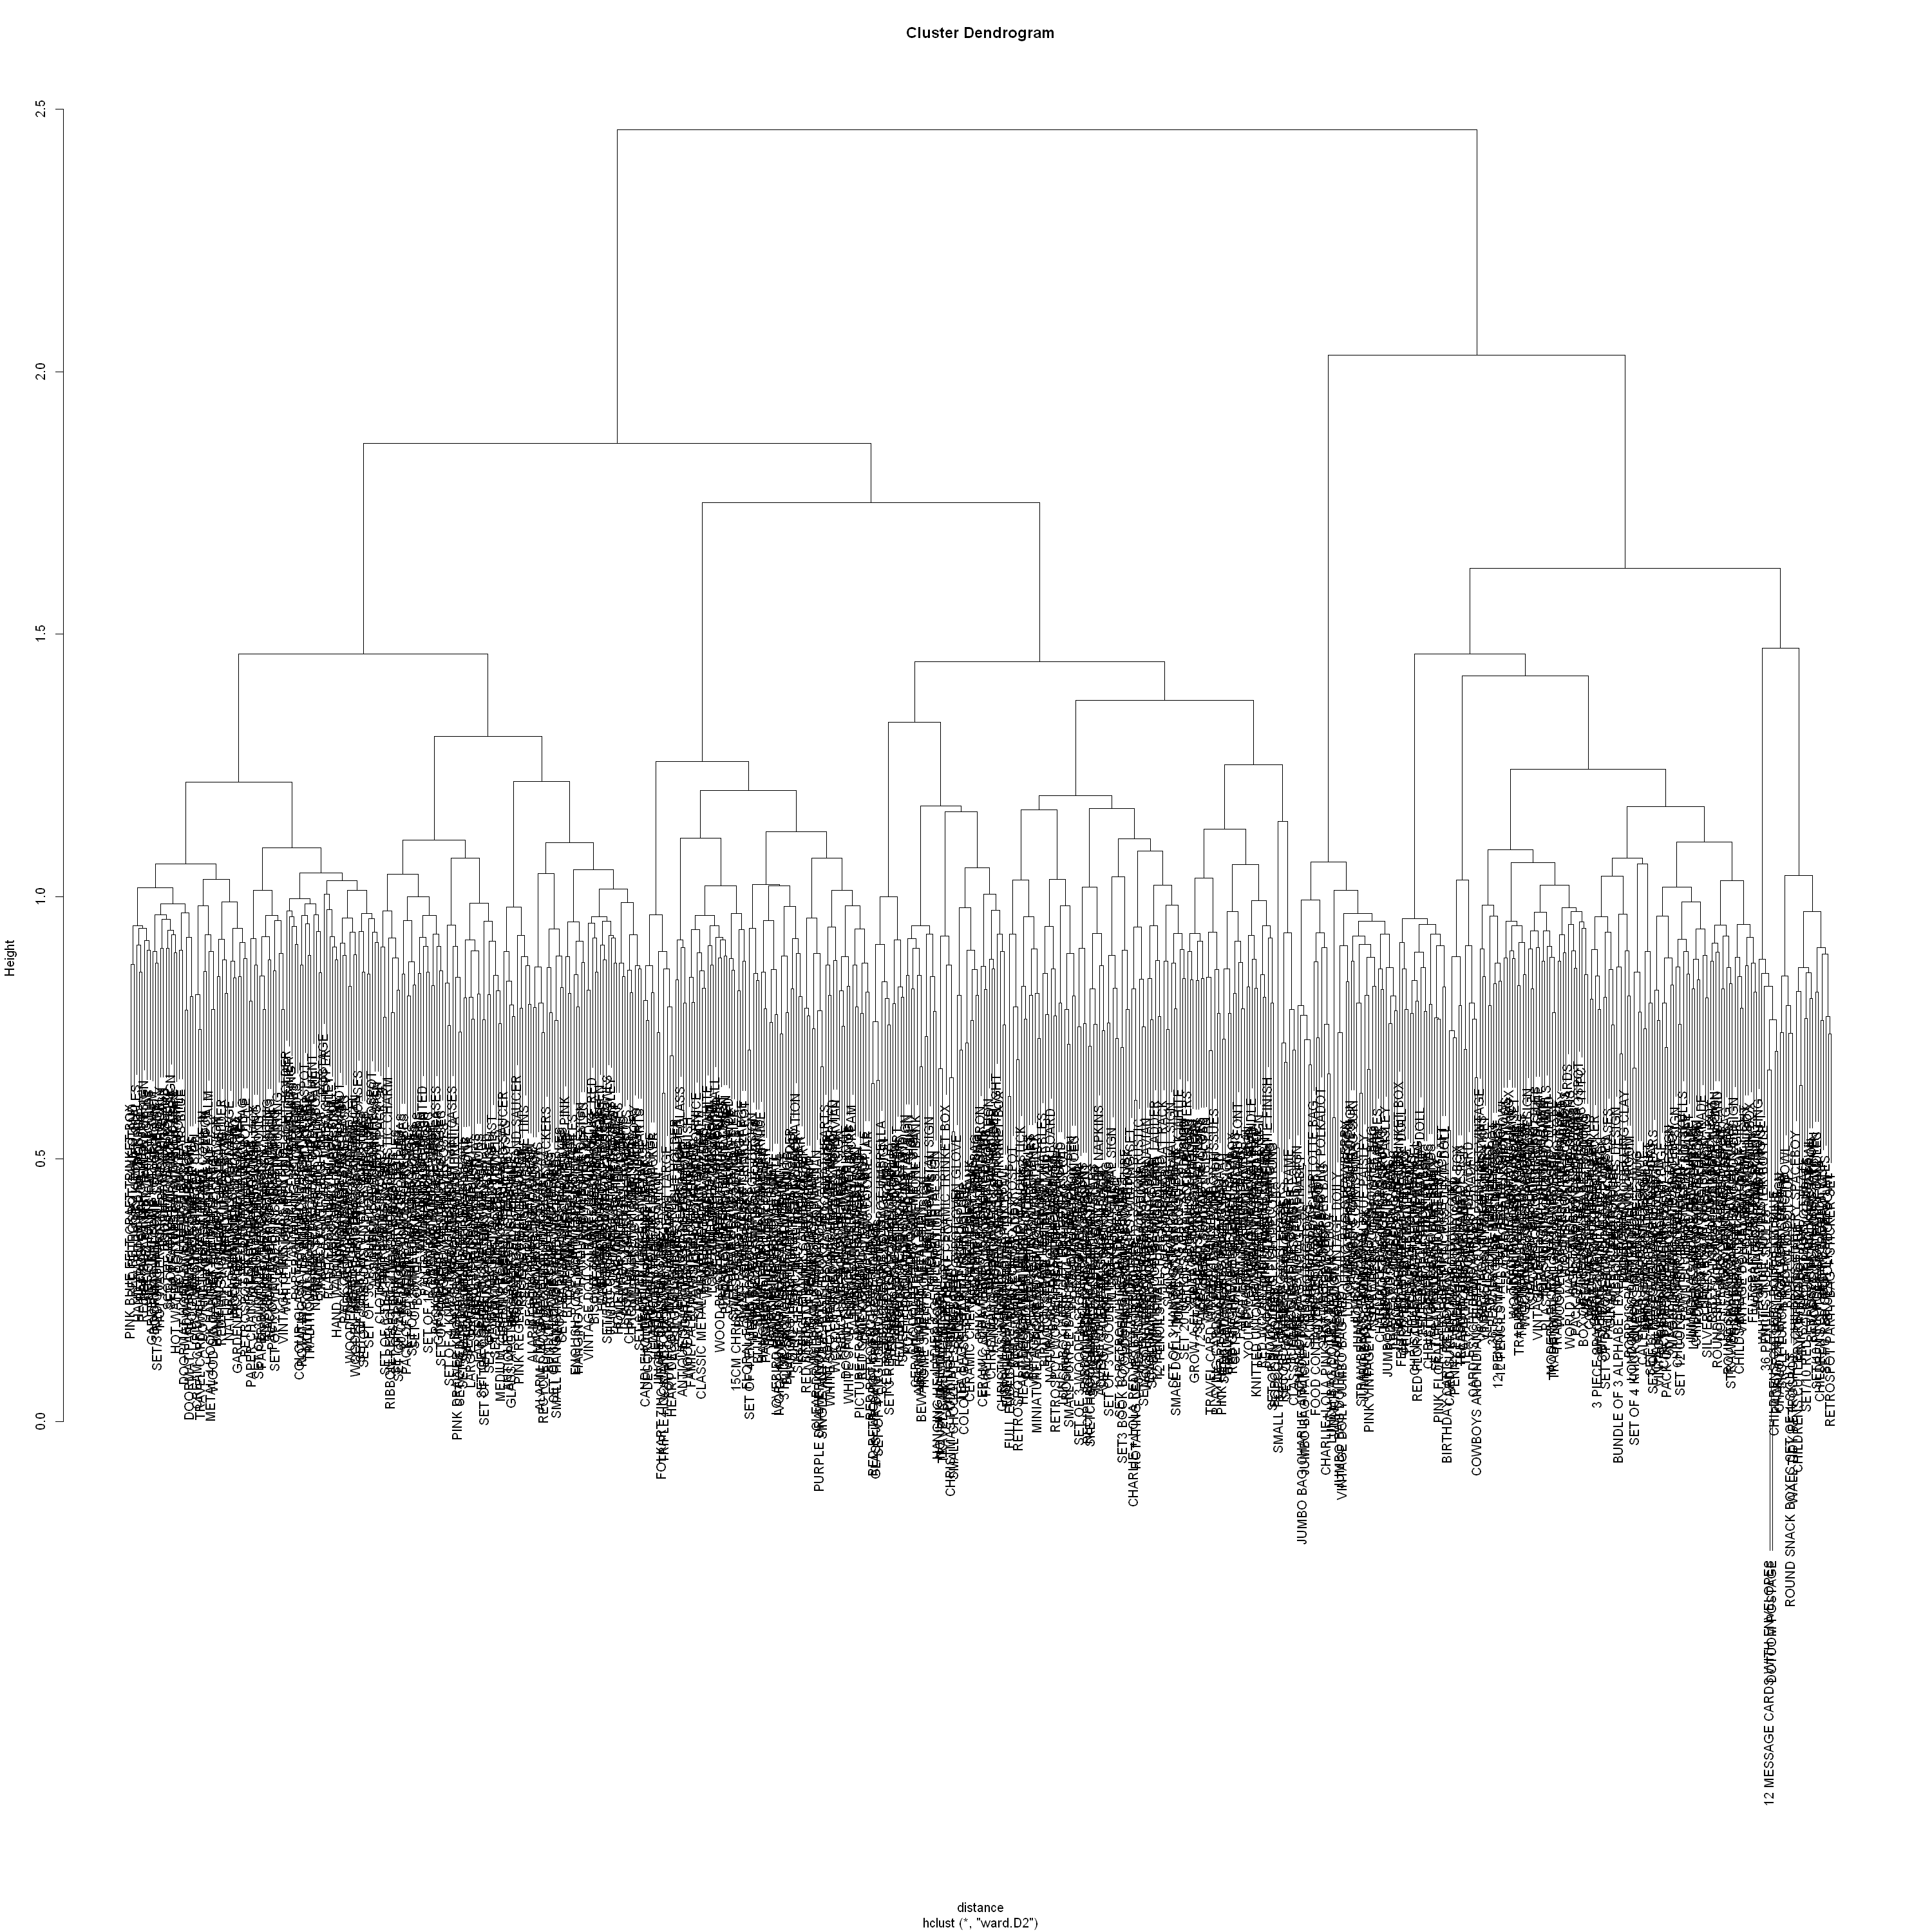

In [21]:
hc.l = hclust(distance, method = "ward.D2")
options(repr.plot.width=25, repr.plot.height=25)
plot(hc.l)

### Suggest the amount of clusters

In [22]:
### To suggest the optimal number of clusters, two methods can be used:
### NbClust - R package, which allows to recommend number of clusters in automatic way

In [23]:
res = NbClust(data = NULL, diss = distance, distance = NULL, min.nc = 2, max.nc = 50, method = "ward.D2", index = "frey")


 Only frey, mcclain, cindex, sihouette and dunn can be computed. To compute the other indices, data matrix is needed 


In [24]:
#Only one cluster for ward method?
#In future it could be worth to try other methods
res$Best.nc

Number_clusters     Value_Index 
              1              NA

In [25]:
### Customize method, which was developed during PoC:
### Compute the sum of distances within each cluster and perfrom weighted average of the sum of distances
### Main goal: minimize the sum of the distances within the cluster 
### until the point where its no longer worth the additional cost of having more clusters (knee of a curve)

In [26]:
###Remove duplicated rules
data = identify_cannibilizers_final %>%
group_by(grp = paste(pmax(identify_cannibilizers_final$LHS, identify_cannibilizers_final$RHS), pmin(identify_cannibilizers_final$LHS, identify_cannibilizers_final$RHS), sep = "_")) %>%
  slice(1) %>%
  ungroup() %>%
  select(-grp)

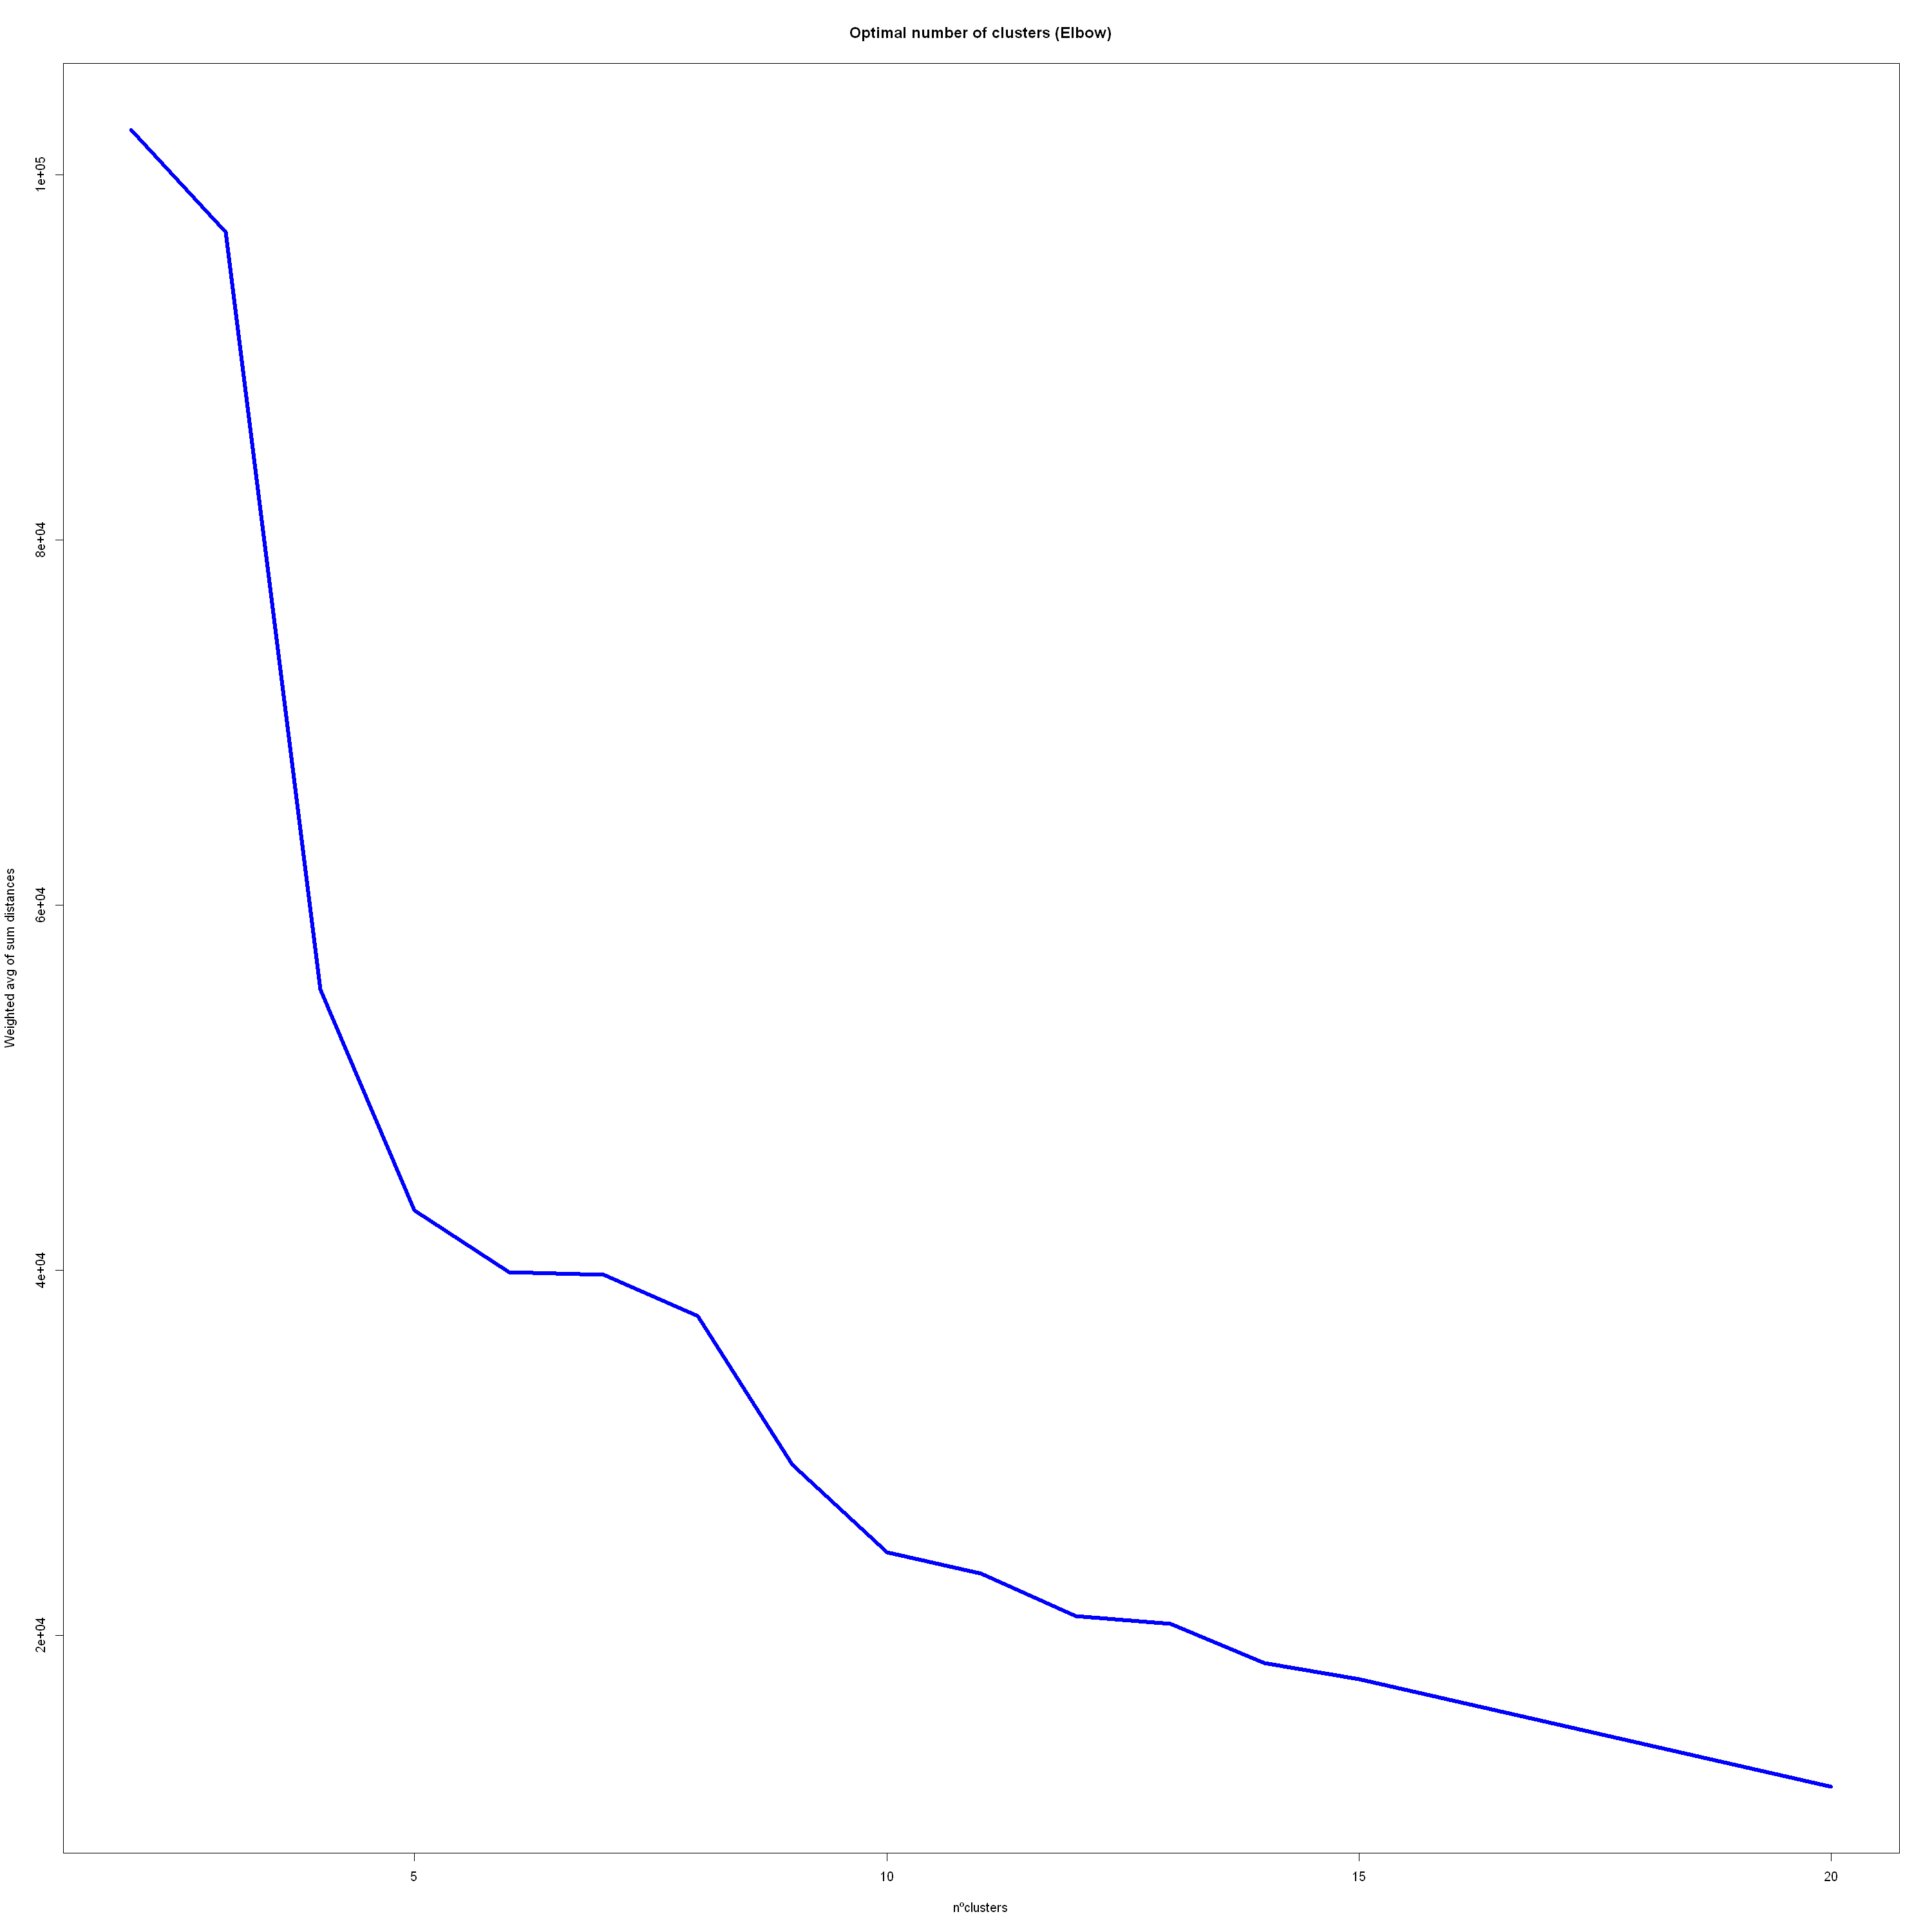

In [27]:
n_clusters = c(2,3,4,5,6,7,8,9,10,11,12,13,14,15,20)
cluster_distance_temp = c()
cluster_distance = as.data.frame(cluster_distance_temp)

for (val in n_clusters) {
  
  clusters = cutree(hc.l, val)
  clusters_df = as.data.frame(cbind(indices(matrix_dist), clusters))
  clusters_df = clusters_df %>% rownames_to_column("article_description")
  colnames(clusters_df)[2] = 'clusters_KPI1'
  
  test_distances = merge(x = clusters_df, y = data, by.x = "article_description", by.y = "LHS")

  sum_distance_cluster = aggregate(test_distances$KPI_1_std_inverse, by=list(clusters_KPI1=test_distances$clusters_KPI1), FUN=sum)
  clusters_count = clusters_df %>% count(clusters_df$clusters_KPI1)
  colnames(clusters_count)[1] = 'clusters_KPI1'
  
  join = merge(sum_distance_cluster, clusters_count, by = "clusters_KPI1")
  sum_distance = weighted.mean(join$x, join$n)
  cluster_distance_temp = c(val, sum_distance)
  cluster_distance = rbind(cluster_distance, cluster_distance_temp)
  
}

colnames(cluster_distance) = c("clusters", "weighted_avg_sum_distance")
plot(cluster_distance$clusters, cluster_distance$weighted_avg_sum_distance, type="l", col="blue", lwd=5,  xlab="nºclusters", ylab="Weighted avg of sum distances", main="Optimal number of clusters (Elbow)")

In [28]:
### To automatize the whole process, elbow finder function was developed:
### scripted elbow method allows to identify the cut off point (curve knee) in automatic way 

### Find optimal number of clusters

In [29]:
#####Elbow finder

elbow_finder <- function(x_values, y_values) {

  ###Save max number of clusters
  max_x_x <- max(x_values)
  ###Save KPI with max number of clusters
  max_x_y <- y_values[which.max(x_values)]
  ###Save max number of KPI
  max_y_y <- max(y_values)
  ###Save clusters with max number of KPI
  max_y_x <- x_values[which.max(y_values)]
  
  max_df <- data.frame(x = c(max_y_x, max_x_x), y = c(max_y_y, max_x_y))
  # Creating straight line between the max values
  fit <- lm(max_df$y ~ max_df$x)
 
  line = c()
  for (i in n_clusters) {
    
    y = fit$coefficients[1]+fit$coefficients[2]*i
    line = rbind(line, c(i,y))
    
  }

  line = data.frame(line)
  colnames(line) = c("clusters", "y")
  line$diff = round(abs(line$y - cluster_distance$weighted_avg_sum_distance),2)
  
  return(cat("Recommended number of clusters is", line[line$diff == max(line$diff),1]))  

}

elbow_finder(cluster_distance$clusters, cluster_distance$weighted_avg_sum_distance)

Recommended number of clusters is 5

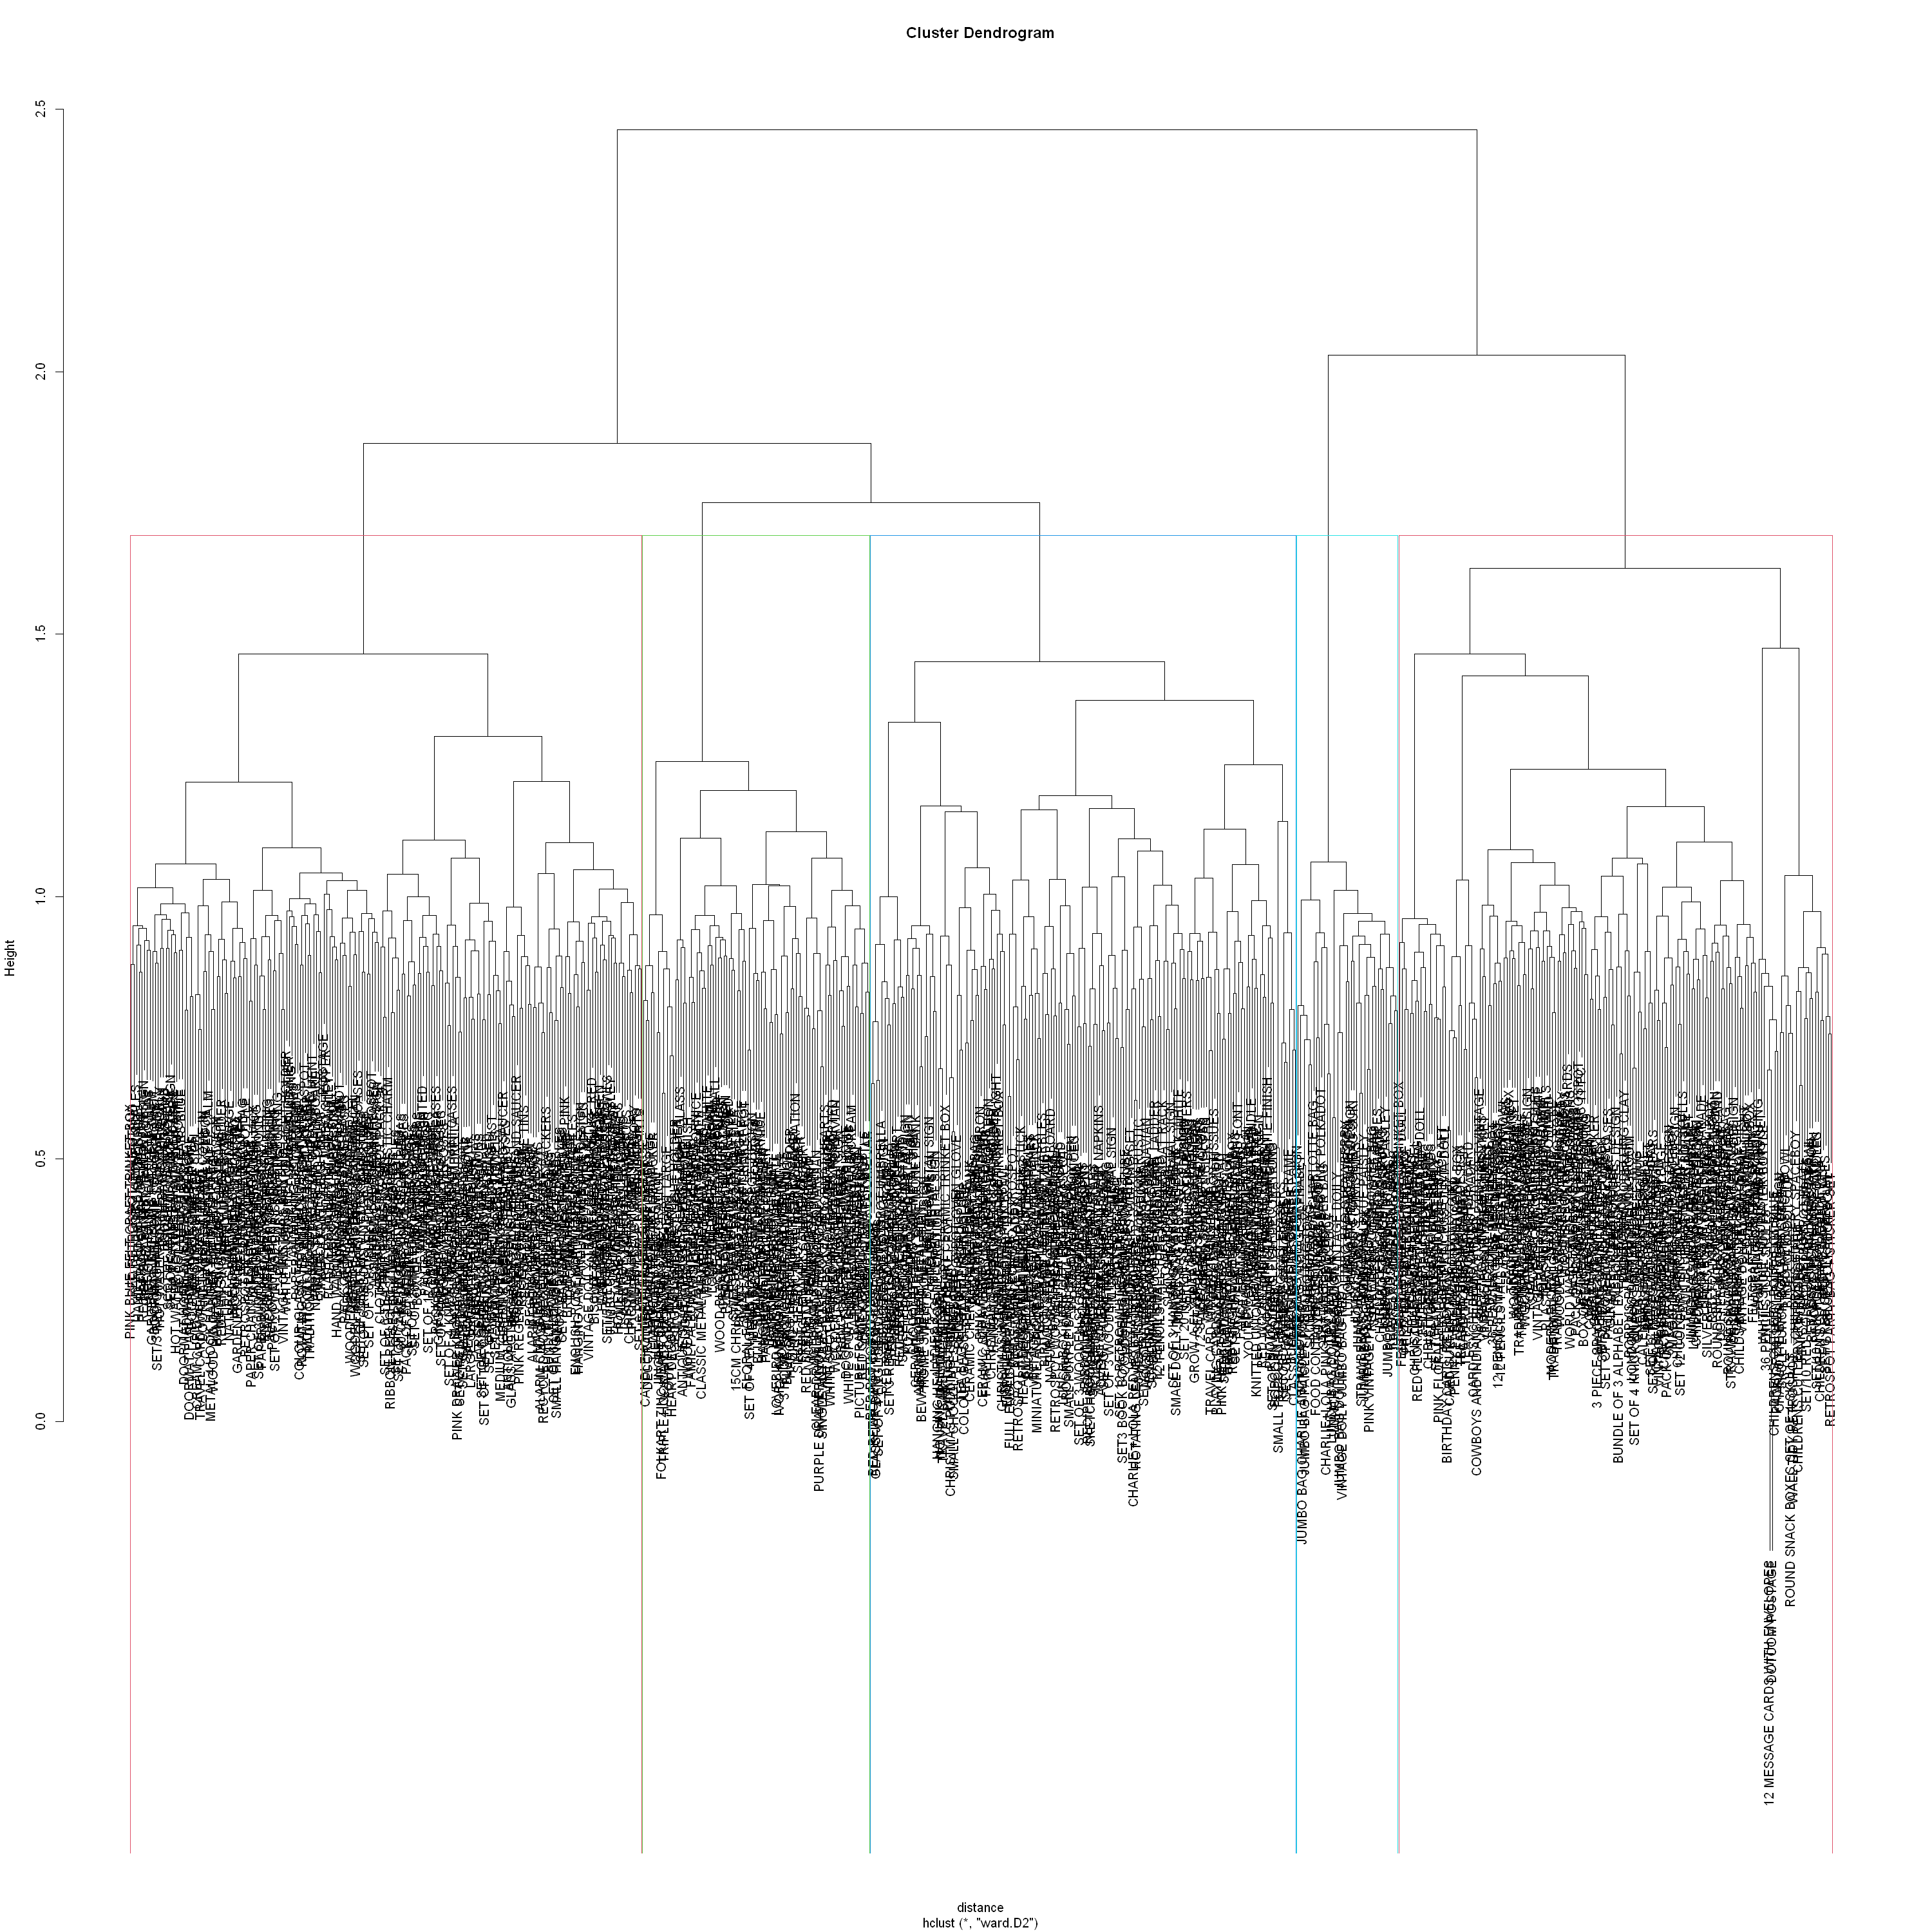

In [30]:
###As we can see by the elbow grap and elbow finder function the optimal number of clusters is 5
hc.l = hclust(distance, method = "ward.D2")
options(repr.plot.width=25, repr.plot.height=25)
plot(hc.l)
rect.hclust(hc.l, k=5, border=2:5)